In [2]:
options(repr.plot.width=8, repr.plot.height=6, repr.plot.res = 180)

In [4]:
library(tidyverse)
library(cowplot)
library(ggrepel)
library(stats)

# PART 0. Data Prep

In [6]:
setwd("/Users/chaodai/qBio/BSD-QBio6/tutorials/data_visualization")

# read in pheno
source(c("readpheno.R"))

# read in hmdp
hmdp = read_csv("hmdp.csv")

# gwscan
gwscan = read_csv('gwscan.csv') %>%
    mutate_at('chr', ~factor(.x, levels = 1:19))

# geno
geno = read_csv("geno_rs29477109.csv", col_types = cols(id = 'c', dosage = 'd'))

Parsed with column specification:
cols(
  strain = col_character(),
  id = col_character(),
  sex = col_character(),
  totalbody = col_double(),
  femur = col_double(),
  spine = col_double()
)

Parsed with column specification:
cols(
  id = col_character(),
  chr = col_double(),
  pos = col_double(),
  abnormalBMD = col_double()
)



## Part A. Exploratory

### 1. Eistribution of tibialis anterior (TA)

**Answer:**

- Yes, the distribution of TA weight is roughly normal. 
- There are mostly small outliers. Specificly, if we define the outliers as falling outside of [25th percentile - 1.5 IQR, 75th percentile + 1.5 IQR], then there are `28` outliers: 
    - `15` outliers < 42.8
    - `13` outliers > 74.8

Warning message:
“Removed 29 rows containing non-finite values (stat_bin).”


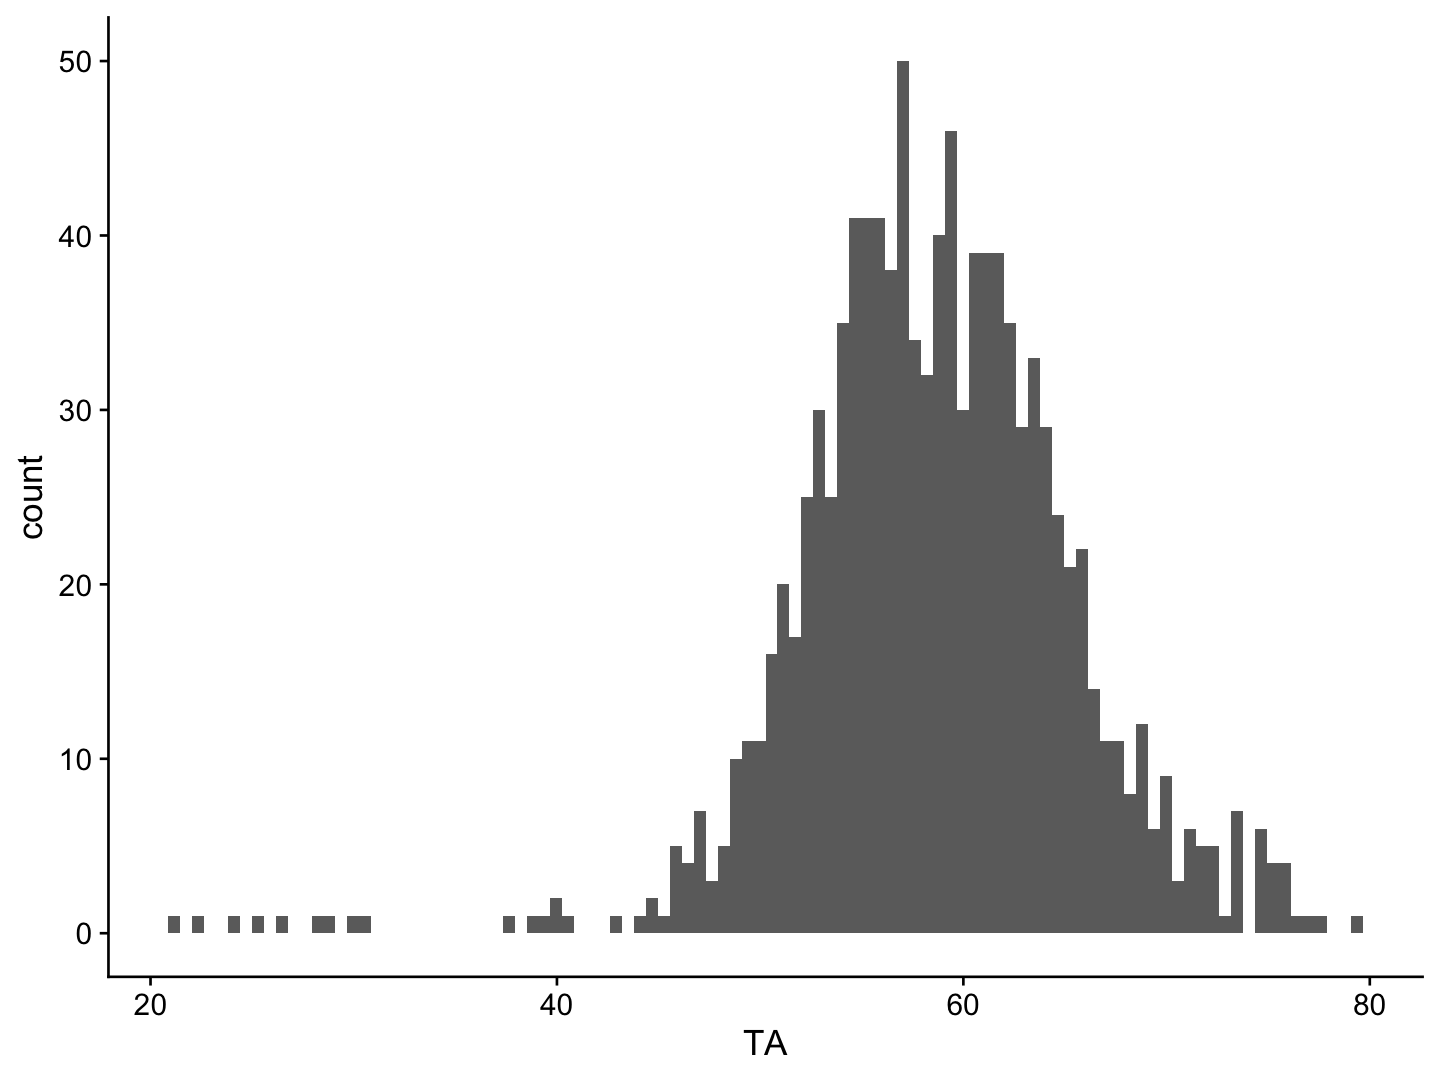

In [11]:
ggplot(pheno) + geom_histogram(aes(TA), bins = 100, alpha = .9) +
    theme_cowplot()

#### set cutoffs as standard outlier criteria [1st Q - 1.5 IQR, 3rd q + 1.5 IQR] 

Based on this criteria, there are 28 outliers

In [12]:
TA.cutoffs = quantile(pheno$TA, na.rm = T, probs = c(.25, .75)) + c(-1.5, 1.5) * IQR(pheno$TA, na.rm = T)

In [13]:
TA.cutoffs

25%  75% 
42.8 74.8

In [19]:
filter(pheno, TA < TA.cutoffs[1] | TA > TA.cutoffs[2]) %>% pull(TA) %>% sort %>% length
filter(pheno, TA < TA.cutoffs[1]) %>% nrow
filter(pheno, TA > TA.cutoffs[2]) %>% nrow

[1] 28

[1] 15

[1] 13

## 2. Visualize `tibia` vs. `TA`

**Answers:** It appears tibia bone length is positively correlated to TA weight. This correlation is observed even without removing the outliers. `RSS` increased after removing the outliers, increasing the fitness of the model. 

See `coef(lm.tibia_ta)` and `coef(lm.tibia_ta.ro) for model coefficients. 


### Before removing outliers

In [21]:
lm.tibia_ta = lm(tibia ~ TA, pheno)

In [46]:
summary(lm.tibia_ta)


Call:
lm(formula = tibia ~ TA, data = pheno)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.4694 -0.2690  0.0087  0.2681  1.4018 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 16.897321   0.110263  153.25   <2e-16 ***
TA           0.025527   0.001866   13.68   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4143 on 1055 degrees of freedom
  (35 observations deleted due to missingness)
Multiple R-squared:  0.1507,	Adjusted R-squared:  0.1499 
F-statistic: 187.2 on 1 and 1055 DF,  p-value: < 2.2e-16


Warning message:
“Removed 35 rows containing missing values (geom_point).”


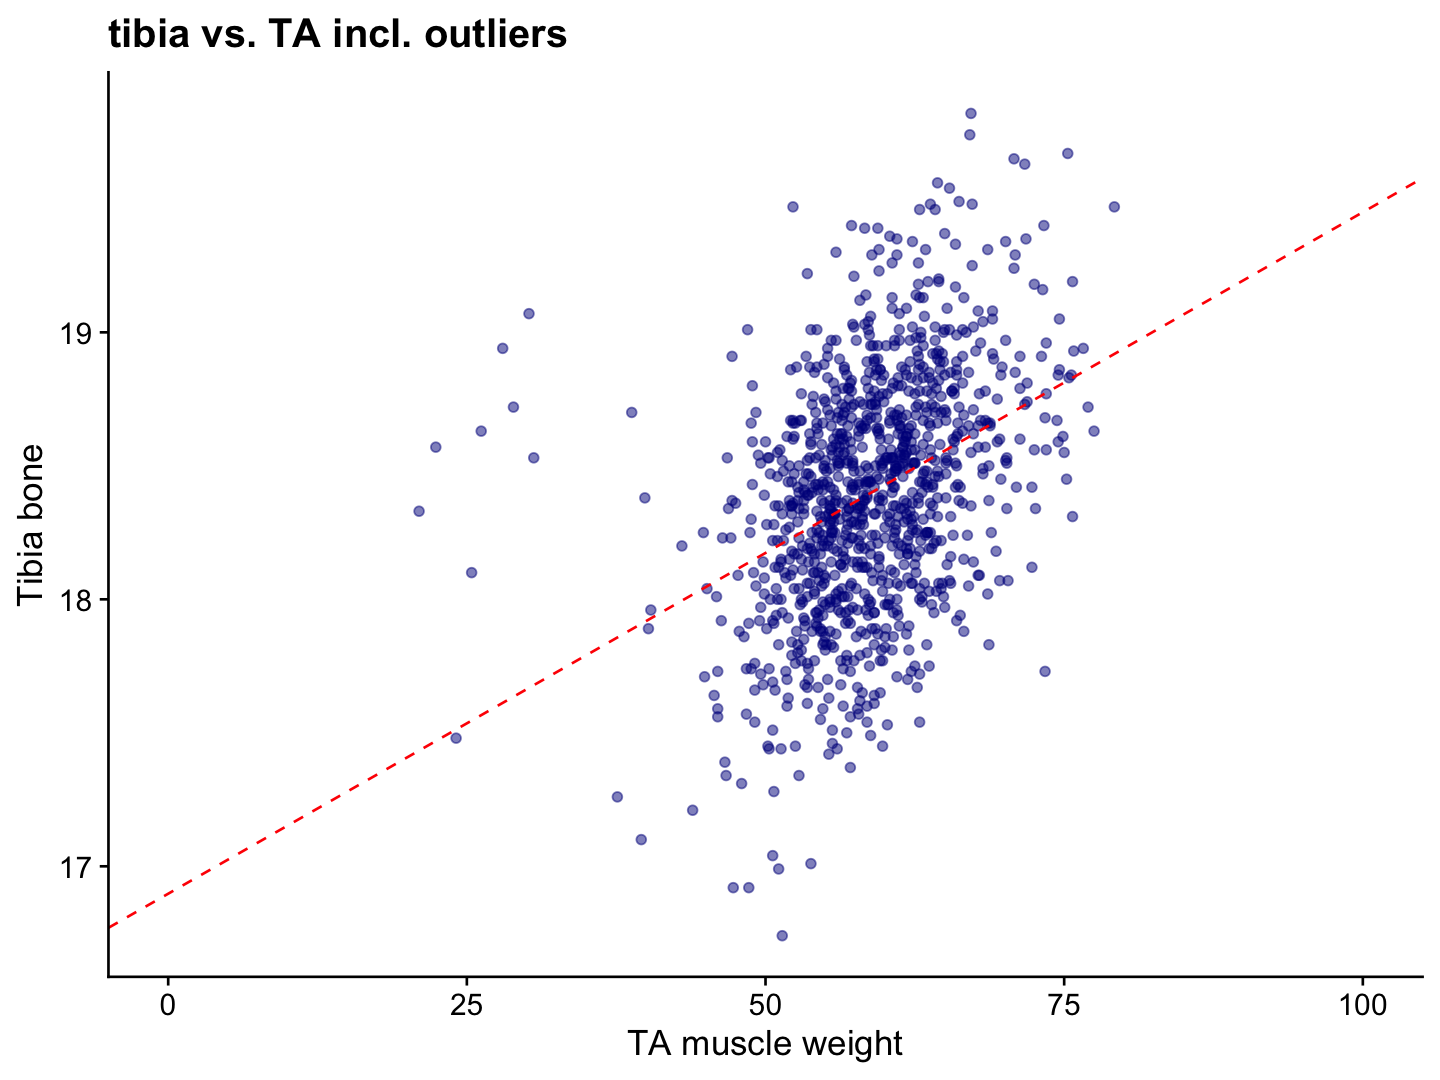

In [40]:
ggplot(pheno) + geom_point(aes(TA, tibia), alpha = .5, color = 'darkblue') +
    geom_abline(slope = coef(lm.tibia_ta)[2], intercept = coef(lm.tibia_ta)[1], color = 'red', linetype = 'dashed') +
    theme_cowplot() +
    labs(x = "TA muscle weight", y = 'Tibia bone', title = "tibia vs. TA incl. outliers") +
    coord_cartesian(xlim = c(0,100))

In [24]:
# remove outliers
pheno.ro = filter(pheno, TA >= TA.cutoffs[1] & TA <= TA.cutoffs[2])

In [25]:
lm.tibia_ta.ro = lm(tibia ~ TA, pheno.ro)

In [45]:
summary.lm(lm.tibia_ta.ro)


Call:
lm(formula = tibia ~ TA, data = pheno.ro)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.4044 -0.2766  0.0047  0.2780  1.2958 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 16.441191   0.129941  126.53   <2e-16 ***
TA           0.033136   0.002197   15.08   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4025 on 1027 degrees of freedom
  (6 observations deleted due to missingness)
Multiple R-squared:  0.1814,	Adjusted R-squared:  0.1806 
F-statistic: 227.5 on 1 and 1027 DF,  p-value: < 2.2e-16


Warning message:
“Removed 6 rows containing missing values (geom_point).”


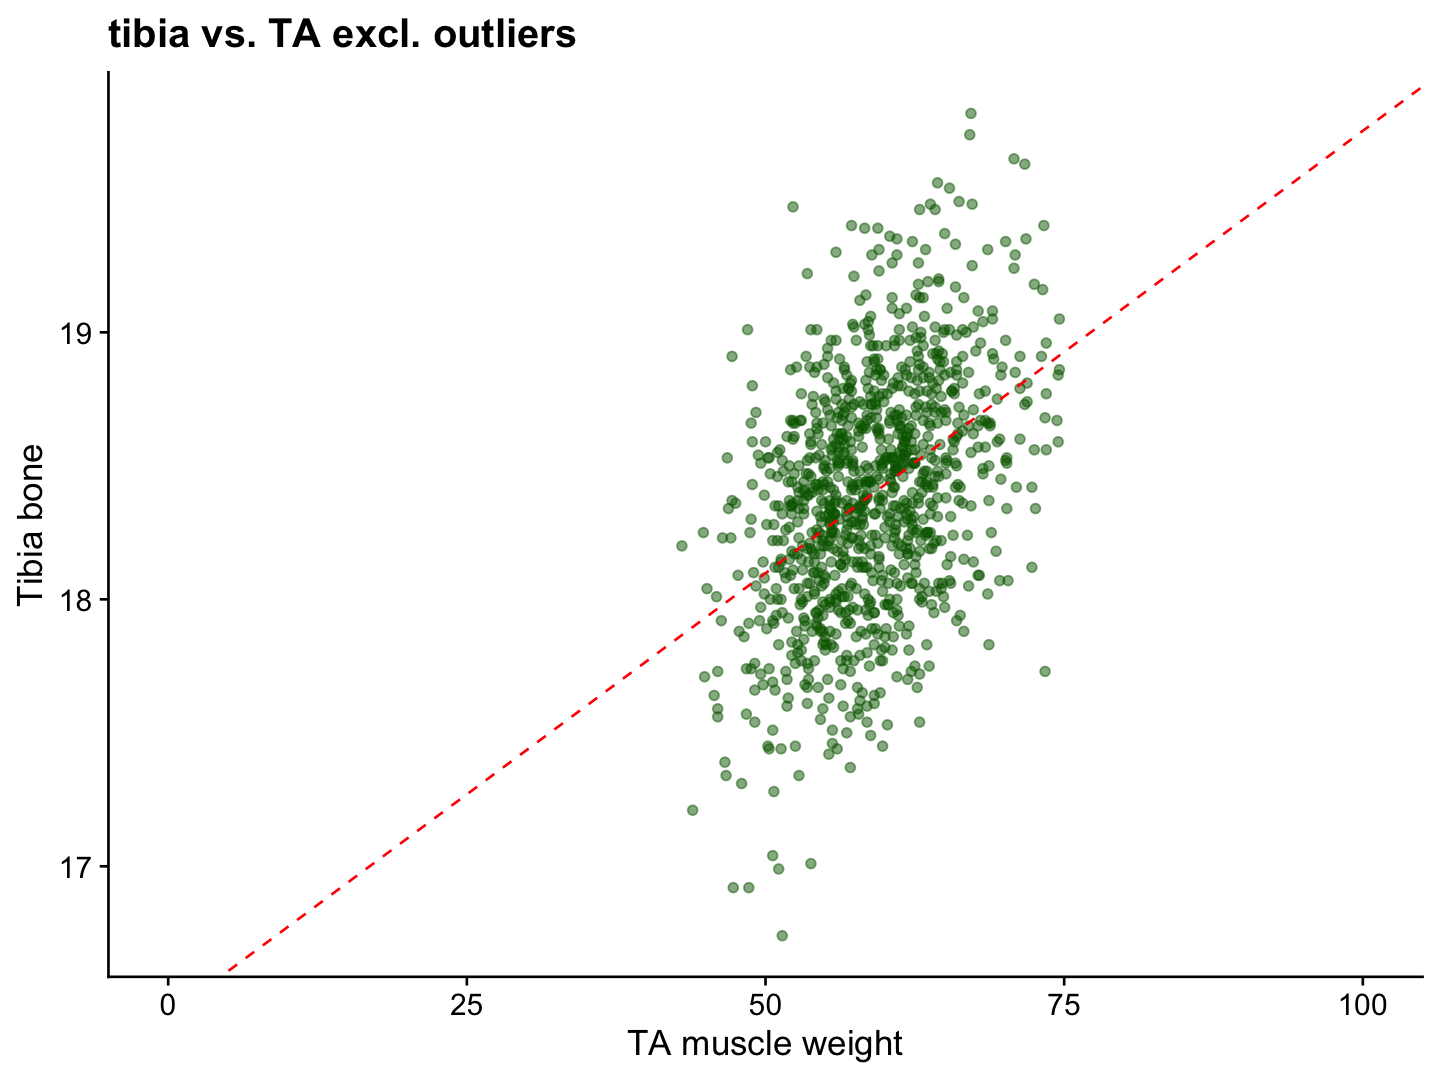

In [43]:
ggplot(pheno.ro) + geom_point(aes(TA, tibia), alpha = .5, color = 'darkgreen') +
    geom_abline(slope = coef(lm.tibia_ta.ro)[2], intercept = coef(lm.tibia_ta.ro)[1], color = 'red', linetype = 'dashed') +
    theme_cowplot() +
    labs(x = "TA muscle weight", y = 'Tibia bone', title = 'tibia vs. TA excl. outliers') +
    coord_cartesian(xlim = c(0,100))

## 3. Conditioned Fear test `AvToneD3`

### Distribution of `AvToneD3`, before logit transformation

**Answer:** The distribution is not a normal distribution.

Warning message:
“Removed 62 rows containing non-finite values (stat_bin).”


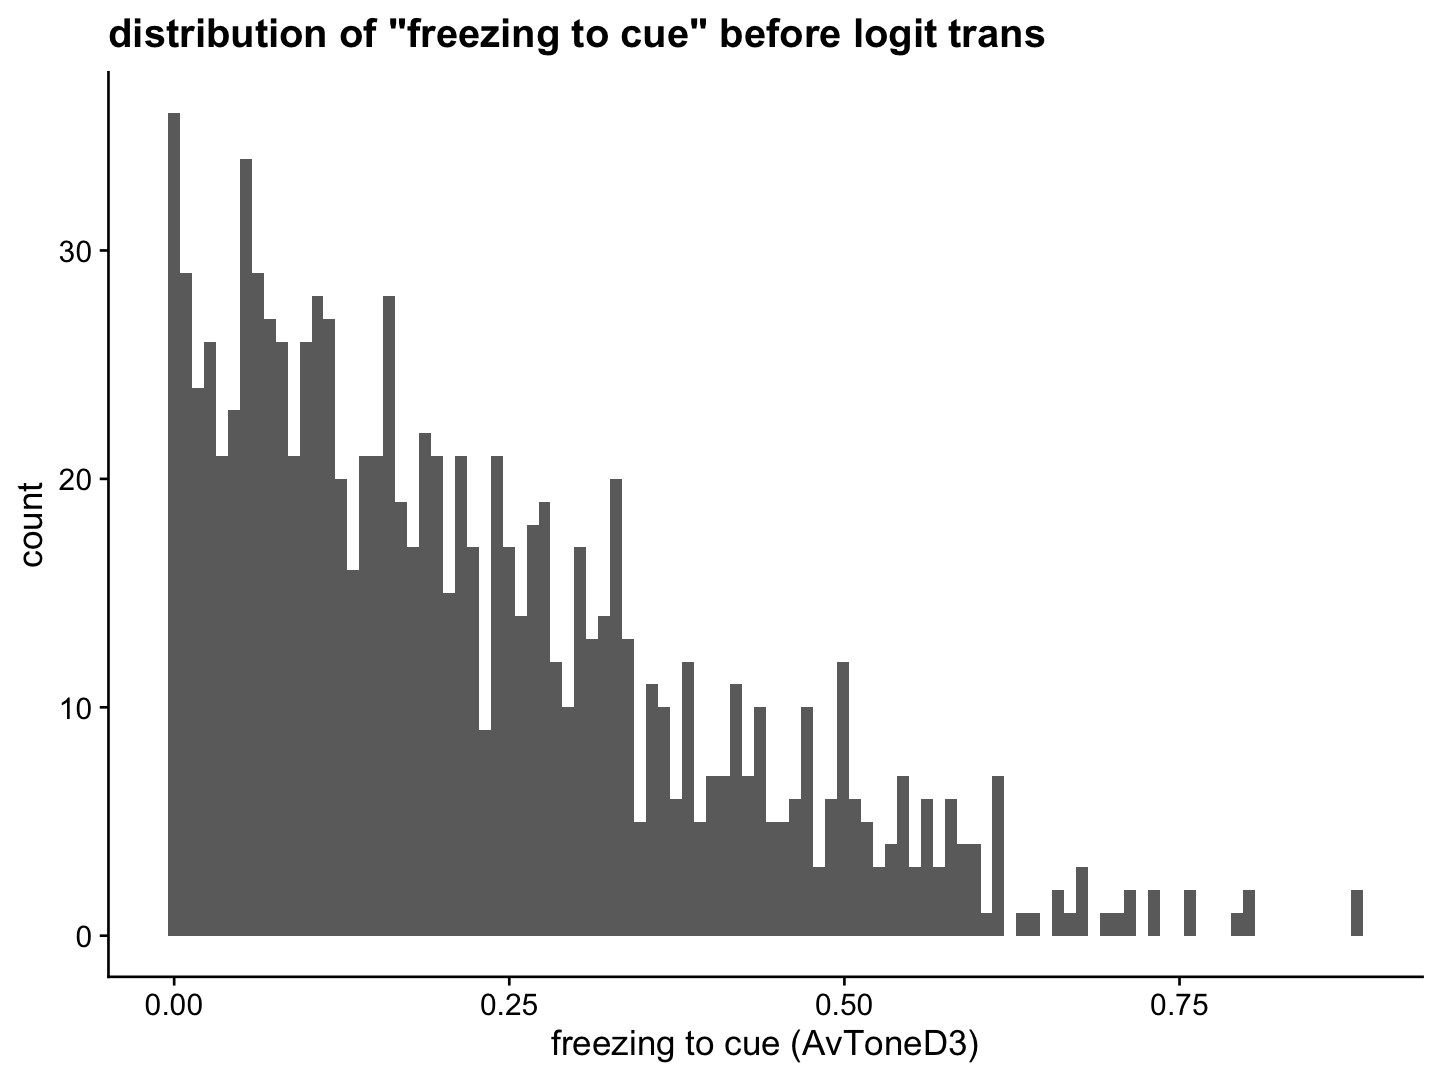

In [53]:
ggplot(pheno) + geom_histogram(aes(AvToneD3), bins = 100, alpha = .9) +
    theme_cowplot() +
    labs(x = 'freezing to cue (AvToneD3)', title = 'distribution of "freezing to cue" before logit trans')

### Distribution of `AvToneD3`, `after` logit transformation

**Answer:** The logit transformed `AvToneD3` is roughly normal distribution. We do observe unusually small values after transformation. That's mainly due to 0 values (29 rows). 

In [57]:
logit = function(x) {
    log((x + .001) / (1 - x + .001))
}

### Boxplot: `AvToneD3` by `FCbox`

**answer**: Box plots show some variation based on device used, but need to do significance test to conclude.

Warning message:
“Removed 62 rows containing non-finite values (stat_boxplot).”


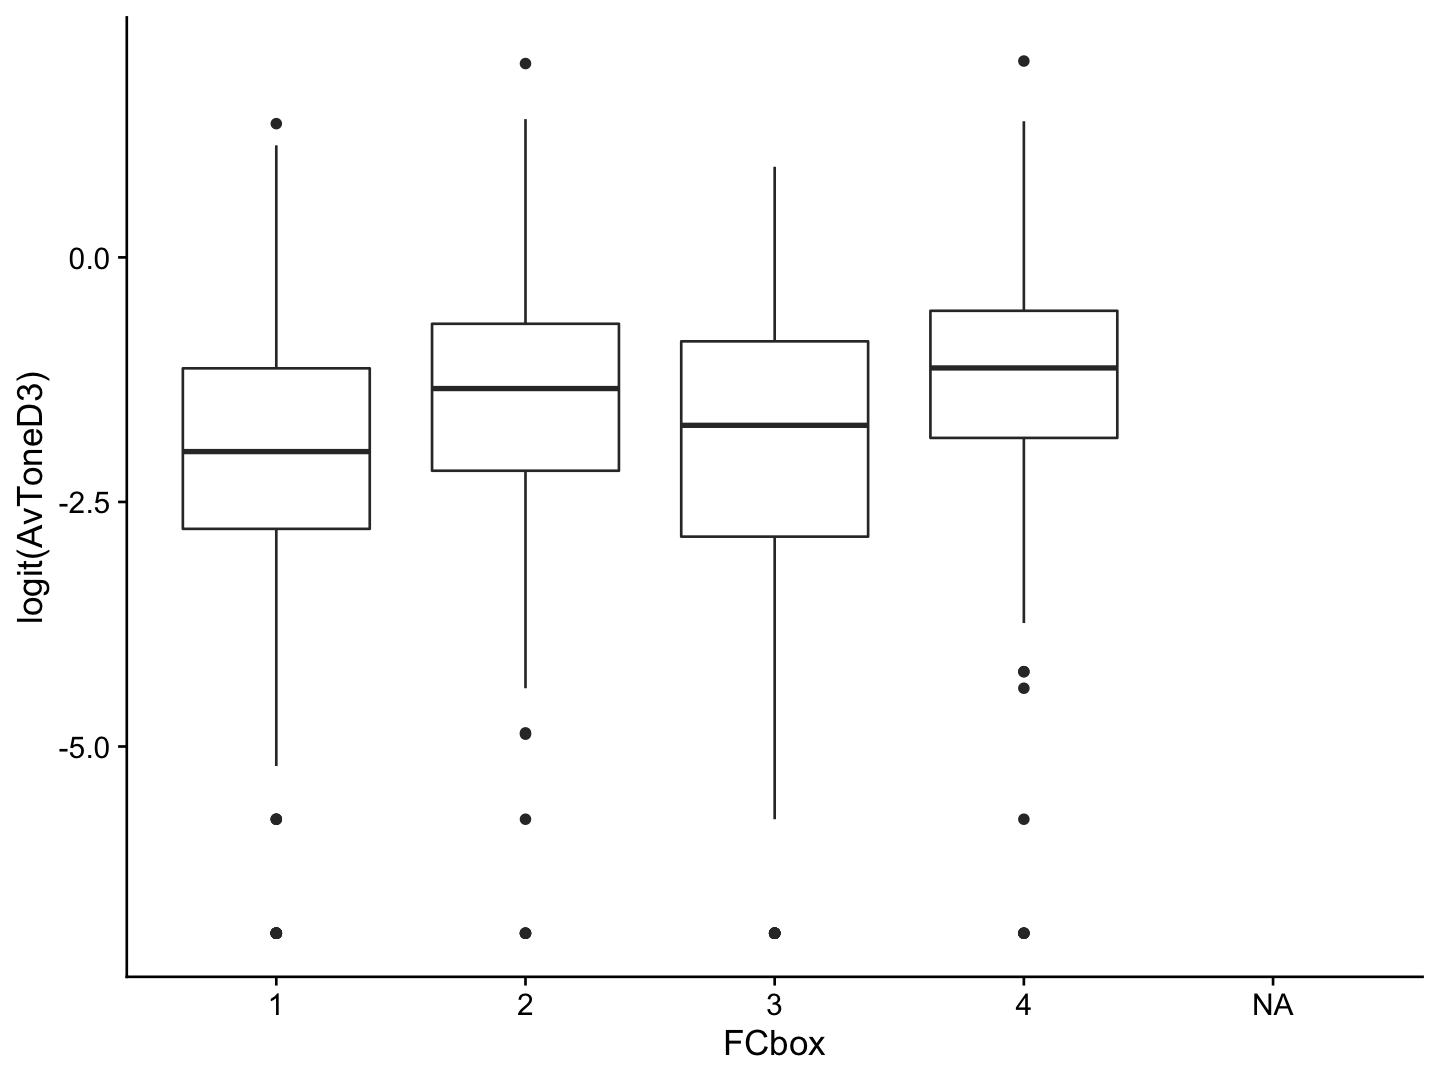

In [60]:
ggplot(pheno) + geom_boxplot(aes(x = FCbox , y = logit(AvToneD3))) +
    theme_cowplot()

# PART B. Exploratory analysis of bone-minaral density

### BMD distribution in CFW mice
**answer:** BMD centers around $75 mg/cm^2$, but has long right tail (large dispersion) of BMD. 

### Compare BMD in CFW mouse and HMDP mouse. 

- BMD in CFW are from femur, and are measured in $mg/cm^2$ units
- BMD in HMDP are from multiple tissues, and are measured in $mg/cm^2$

**answer:** Femur BMD data in CFW is more dispersed than in HMDP. 

Warning message:
“Removed 134 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 13 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


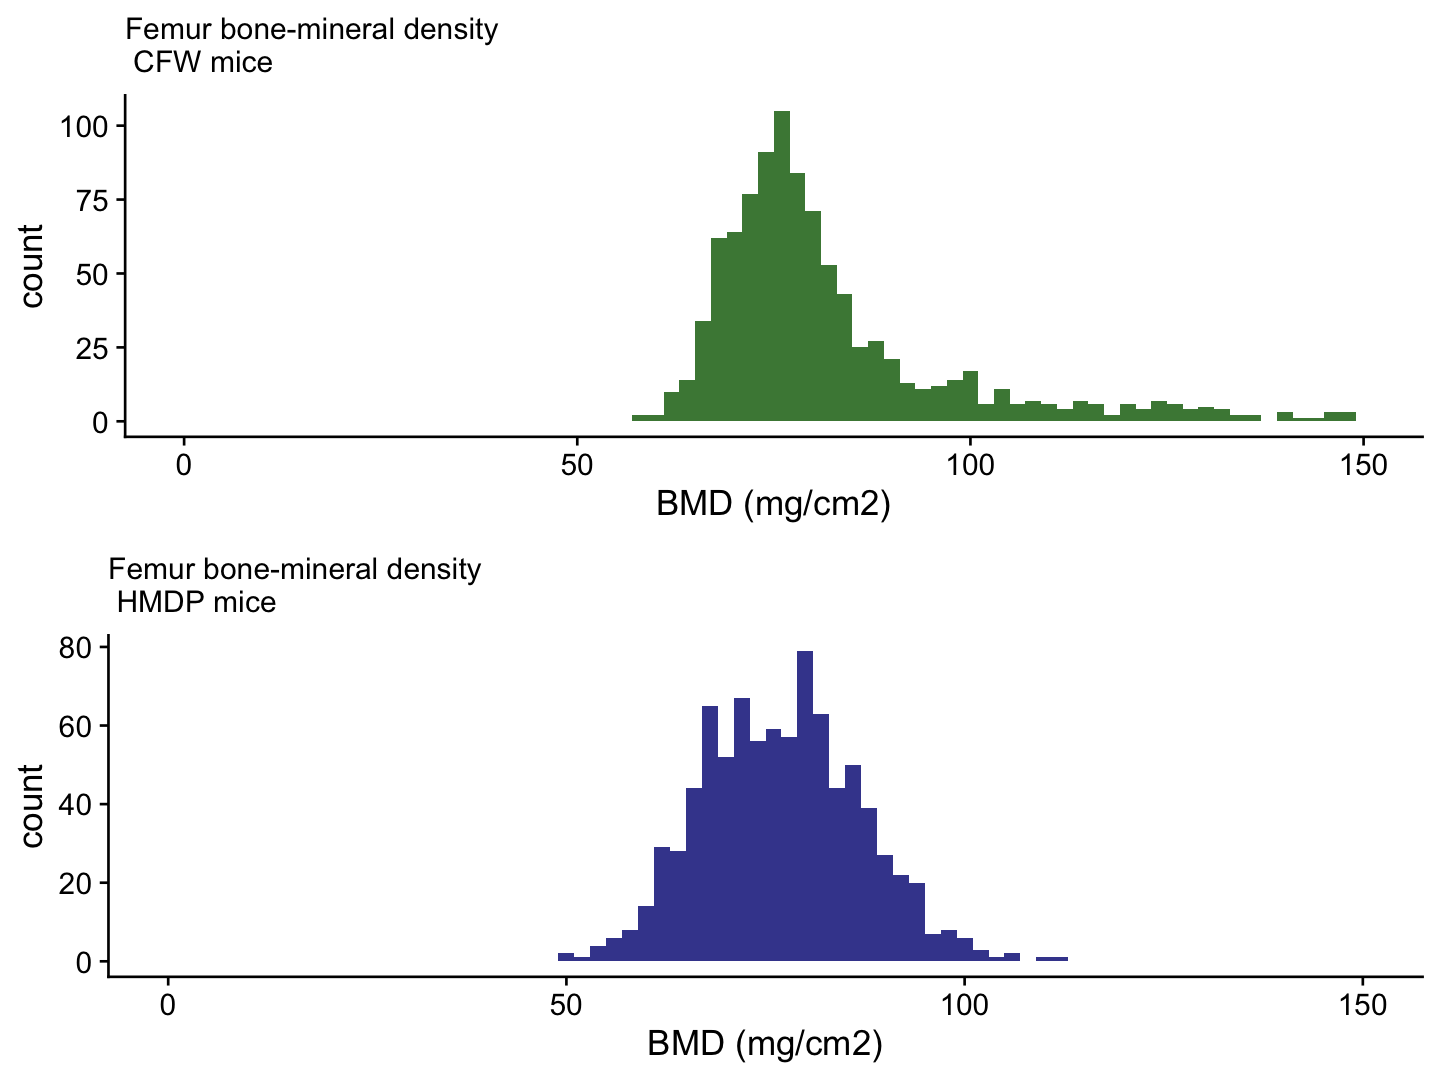

In [124]:
p1 = ggplot(pheno) + geom_histogram(aes(BMD), binwidth = 2, alpha = .8, fill = 'darkgreen') +
    theme_cowplot() +
    xlim(c(0,150)) +
    labs(x = 'BMD (mg/cm2)', subtitle = 'Femur bone-mineral density \n CFW mice')

p2 = ggplot(hmdp) + geom_histogram(aes(femur*1000),binwidth = 2, alpha = .8, fill = 'navy') +
    theme_cowplot() +
    xlim(c(0,150)) +
    labs(x = 'BMD (mg/cm2)', subtitle = 'Femur bone-mineral density \n HMDP mice')

plot_grid(p1, p2, ncol = 1)

# PART C. mapping the genetic basis of osteopetrotic bones

## 1. Manhattan plot for abnormal BMD and SNPs

In [175]:
gwscan = group_by(gwscan, chr) %>% # compute chr size
            summarise(chr_len = max(pos)) %>%

            # start pos for each chr in the cumulative coordinates
            mutate(start_cum = cumsum(chr_len)-chr_len) %>%  
            left_join(gwscan, ., by = 'chr') %>% # add this info to original df
            
            # position of SNP in the cumkulative coordinates
            mutate(pos_cum = pos + start_cum)

`summarise()` ungrouping output (override with `.groups` argument)



In [229]:
head(gwscan, 2)

id,chr,pos,abnormalBMD,chr_len,start_cum,pos_cum
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
cfw-1-3207478,1,3207478,0.035379,195217173,0,3207478
cfw-1-4592184,1,4592184,0.304585,195217173,0,4592184


In [181]:
chr_center_pos =  group_by(gwscan, chr) %>%
        summarise(center = (max(pos_cum) + min(pos_cum))/2)

`summarise()` ungrouping output (override with `.groups` argument)



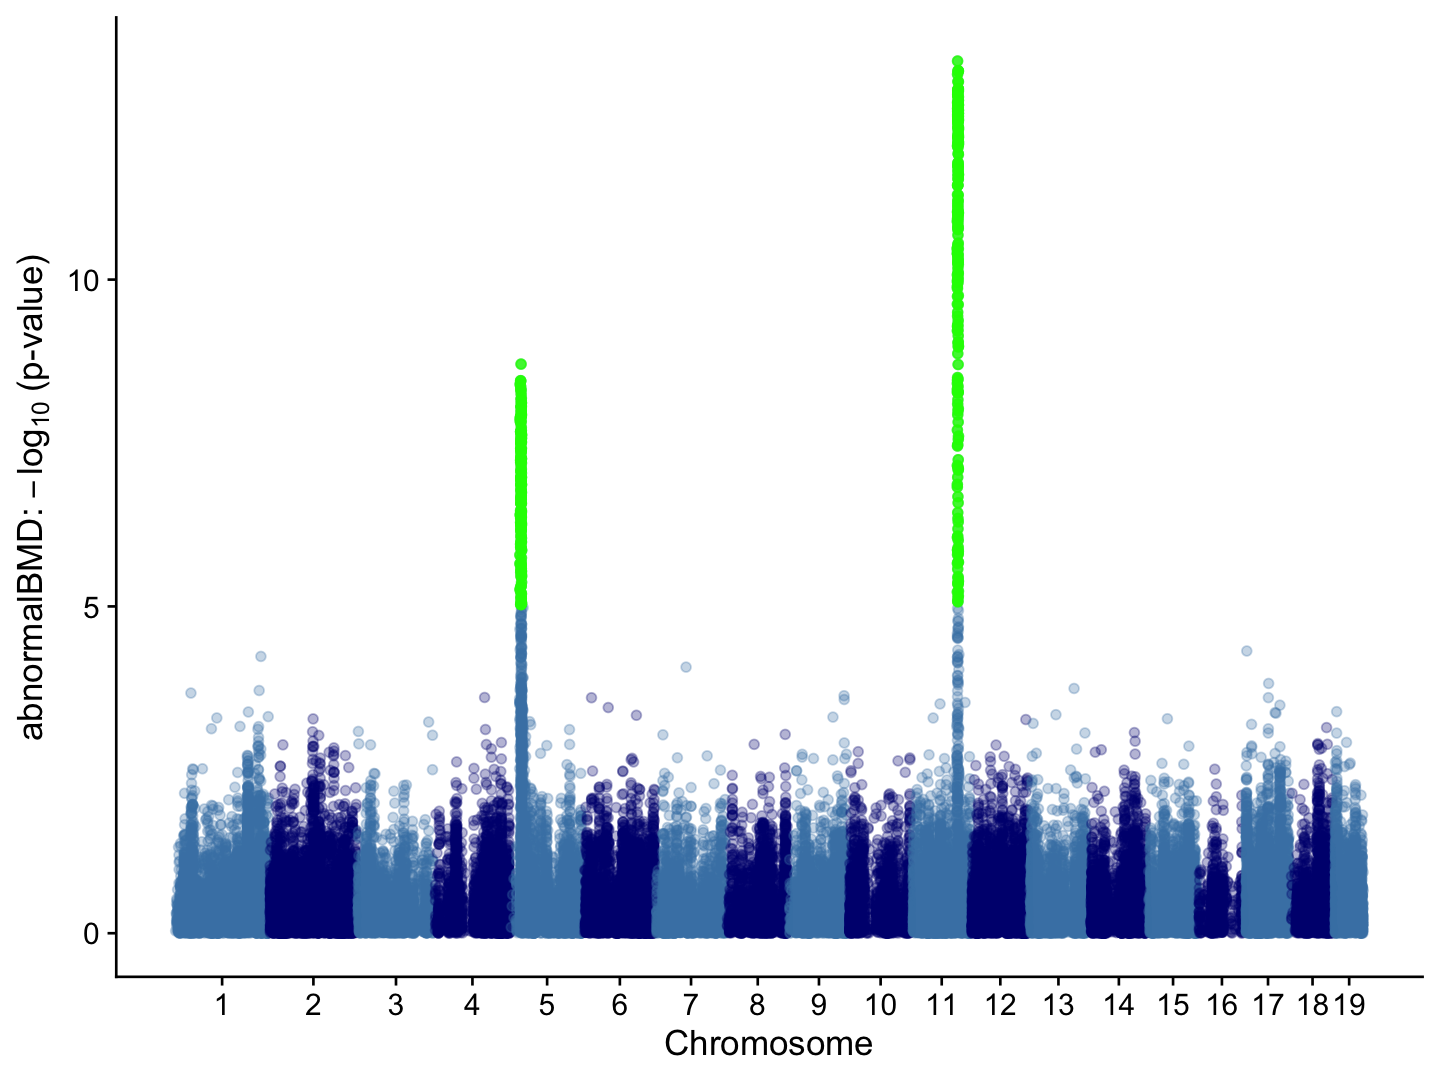

In [218]:
mutate(gwscan, highlight = abnormalBMD > 6) %>%
    ggplot(aes(x = pos_cum, y = abnormalBMD)) +
        geom_point(aes(color = chr), alpha = .3) +
        theme_cowplot() +
        scale_x_continuous(breaks = chr_center_pos$center, labels = chr_center_pos$chr, name = 'Chromosome') + 
        labs(y = bquote("abnormalBMD:" ~ -log[10]~"(p-value)")) +
        scale_color_manual(values = c(rep(c('steelblue','navyblue'),9), 'steelblue')) +
        geom_point(data = filter(gwscan, abnormalBMD > 5), color = 'green', alpha = .8) +
        theme(legend.position = 'none')

How many SNPs have “strong” statistical support for association with abnormal BMD, specifically with a − log10 p-value > 6? 

In [222]:
filter(gwscan, abnormalBMD > 6) %>% pull(id) %>% unique %>% length

[1] 334

In [219]:
head(gwscan)

id,chr,pos,abnormalBMD,chr_len,start_cum,pos_cum
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
cfw-1-3207478,1,3207478,0.035379,195217173,0,3207478
cfw-1-4592184,1,4592184,0.304585,195217173,0,4592184
rs31954814,1,5151352,0.453117,195217173,0,5151352
rs31947195,1,5240999,0.268015,195217173,0,5240999
rs30660852,1,5241015,0.311068,195217173,0,5241015
rs260800880,1,5241052,0.154376,195217173,0,5241052


How many distinct regions of the genome are strongly associated with abnormal BMD at this p-value threshold?

In [224]:
filter(gwscan, abnormalBMD > 6) %>% pull(pos_cum) %>% unique %>% length

[1] 334

What p-value does a − log10 p-value of 6 correspond to?

1e-6

In [228]:
filter(gwscan, abnormalBMD > 6) %>%
    arrange(chr, pos) %>% head

id,chr,pos,abnormalBMD,chr_len,start_cum,pos_cum
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
rs29821439,5,21819251,7.881544,151725817,692768460,714587711
rs31966723,5,21831593,6.401055,151725817,692768460,714600053
rs33669127,5,21840869,8.398464,151725817,692768460,714609329
rs33361596,5,21962004,7.838968,151725817,692768460,714730464
rs265668924,5,22851474,6.463525,151725817,692768460,715619934
rs265501778,5,22877488,7.234207,151725817,692768460,715645948


---